# Goal: Create machine learning model that will sort products based on their title

# Roadmap:


![Mapa](../images/map.jpeg)

## Loading libraries:

In [247]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib





## 1. Raw data gathering

In [248]:
try:
    df = pd.read_csv('../data/products.csv')
    print(df.head(5))
except Exception as e:
    print(f"An unexpected error occurred: {e}")

   product ID                                      Product Title  Merchant ID  \
0           1                    apple iphone 8 plus 64gb silver            1   
1           2                apple iphone 8 plus 64 gb spacegrau            2   
2           3  apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...            3   
3           4                apple iphone 8 plus 64gb space grey            4   
4           5  apple iphone 8 plus gold 5.5 64gb 4g unlocked ...            5   

   Category Label _Product Code  Number_of_Views  Merchant Rating  \
0   Mobile Phones    QA-2276-XC            860.0              2.5   
1   Mobile Phones    KA-2501-QO           3772.0              4.8   
2   Mobile Phones    FP-8086-IE           3092.0              3.9   
3   Mobile Phones    YI-0086-US            466.0              3.4   
4   Mobile Phones    NZ-3586-WP           4426.0              1.6   

   Listing Date    
0       5/10/2024  
1      12/31/2024  
2      11/10/2024  
3        5/2/2022 

## 2. EDA

In [249]:
print("Dataset shape (rows, columns):", df.shape)
print('*' * 40)

print("\nDataset info:")
df.info()
print('*' * 40)


df.describe()

print('*' * 40)

print("Missing values per column:")
print(df.isna().sum())

print('*' * 40)
sample = df.sample(random_state=42, n=5)
print("Random sample of 5 rows:\n", sample)


Dataset shape (rows, columns): (35311, 8)
****************************************

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product ID       35311 non-null  int64  
 1   Product Title    35139 non-null  object 
 2   Merchant ID      35311 non-null  int64  
 3    Category Label  35267 non-null  object 
 4   _Product Code    35216 non-null  object 
 5   Number_of_Views  35297 non-null  float64
 6   Merchant Rating  35141 non-null  float64
 7    Listing Date    35252 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 2.2+ MB
****************************************
****************************************
Missing values per column:
product ID           0
Product Title      172
Merchant ID          0
 Category Label     44
_Product Code       95
Number_of_Views     14
Merchant Rating    170
 L

### Category count

In [250]:
# Count occurrences of each sentiment label
category_counts = df[' Category Label'].value_counts()

# Print counts
print("Category distribution (counts):")
print(category_counts)

Category distribution (counts):
 Category Label
Fridge Freezers     5495
Washing Machines    4036
Mobile Phones       4020
CPUs                3771
TVs                 3564
Fridges             3457
Dishwashers         3418
Digital Cameras     2696
Microwaves          2338
Freezers            2210
fridge               123
CPU                   84
Mobile Phone          55
Name: count, dtype: int64


### Category visualisation

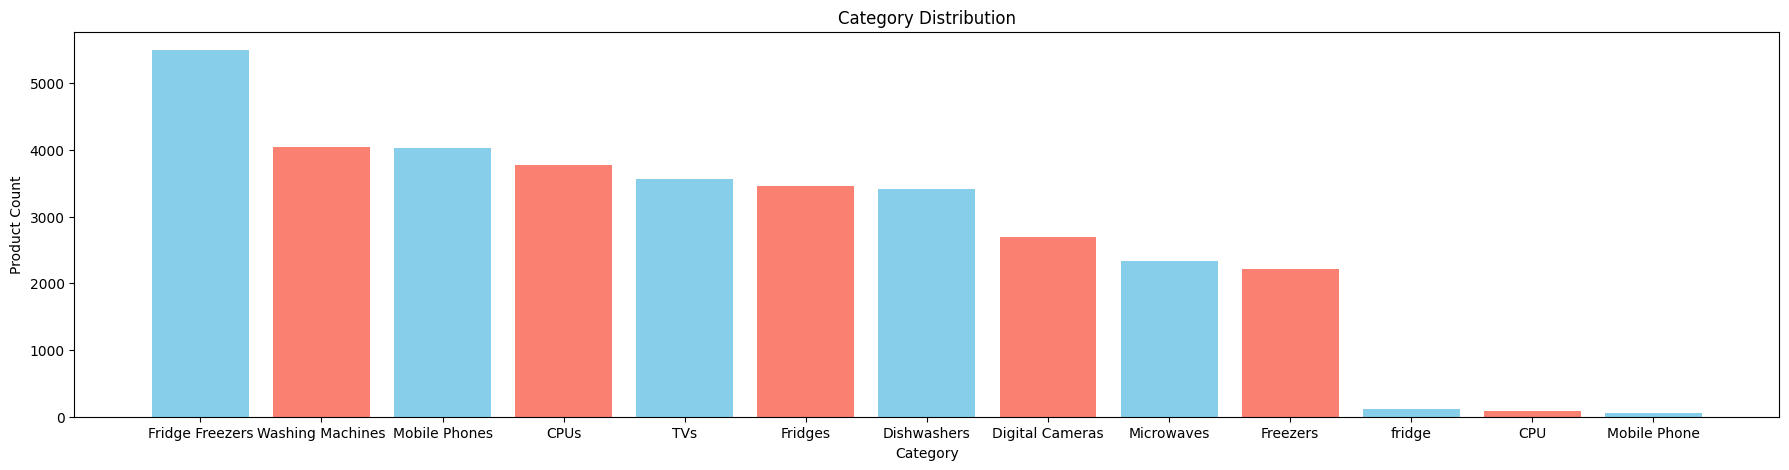

In [251]:
plt.figure(figsize=(22, 5))
plt.bar(category_counts.index, category_counts.values, color=['skyblue', 'salmon'])
plt.title("Category Distribution")
plt.xlabel("Category")
plt.ylabel("Product Count")
plt.show()

## 3. Data processing (cleaning)

3.1 Standardization
3.2 Removing missing values
3.3 Removing duplicates
3.4 Converting data types


In [ ]:
# 3.1 Standardization
def standardize_data(df):
    # Standardize column names
    df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

    df["category_label"] = df["category_label"].replace({
        'Fridges':'Fridge Freezers',
        'Freezers':'Fridge Freezers',
        'fridge':'Fridge Freezers',
        'CPU':'CPUs',
        'Mobile Phone':'Mobile Phones',
    })
    return df


# 3.2 Handling missing values
def handle_missing_values(df):
    df = df.dropna(subset=["product_title", "category_label"])
    return df


# 3.3 Removing duplicates
def deduplicate_data(df):
    return df.drop_duplicates(keep="first", ignore_index=False)

# 3.4 Converting data types
def convert_data_types(df):
    df['category_label'] = df['category_label'].astype('category')
    
    return df


def prepare_data(df):
    return (
        df.pipe(deduplicate_data)
        .pipe(standardize_data) 
        .pipe(handle_missing_values)
        .pipe(convert_data_types)

    )




### Data after cleaning:

In [253]:
df = prepare_data(df)

print("\nRemaining missing values per column:\n", df.isnull().sum())
print('*' * 40)
print(df.dtypes)




Remaining missing values per column:
 product_id           0
product_title        0
merchant_id          0
category_label       0
_product_code       94
number_of_views     14
merchant_rating    170
listing_date        58
dtype: int64
****************************************
product_id            int64
product_title        object
merchant_id           int64
category_label     category
_product_code        object
number_of_views     float64
merchant_rating     float64
listing_date         object
dtype: object


## 4. Feature engineering

### Our goal is to create a model that will sort products by categories based on their titles, so we need to remove columns that are not relevant. Also we will check if title lenght is relevant or not.

****************************************
                    count       mean        std   min   25%   50%   75%    max
category_label                                                                
CPUs               3831.0  67.021404  20.210202  11.0  55.0  65.0  76.0  190.0
Digital Cameras    2689.0  50.115284  24.548060   6.0  34.0  44.0  61.0  180.0
Dishwashers        3405.0  50.206755  17.989980  10.0  39.0  51.0  61.0  192.0
Fridge Freezers   11230.0  51.837756  19.669218   8.0  39.0  50.0  65.0  173.0
Microwaves         2328.0  51.811856  18.798911  11.0  39.0  52.0  65.0  164.0
Mobile Phones      4057.0  46.240818  30.759028   5.0  27.0  40.0  57.0  200.0
TVs                3541.0  54.719006  23.394549   6.0  40.0  53.0  65.0  195.0
Washing Machines   4015.0  53.042839  18.853608  10.0  42.0  54.0  65.0  149.0


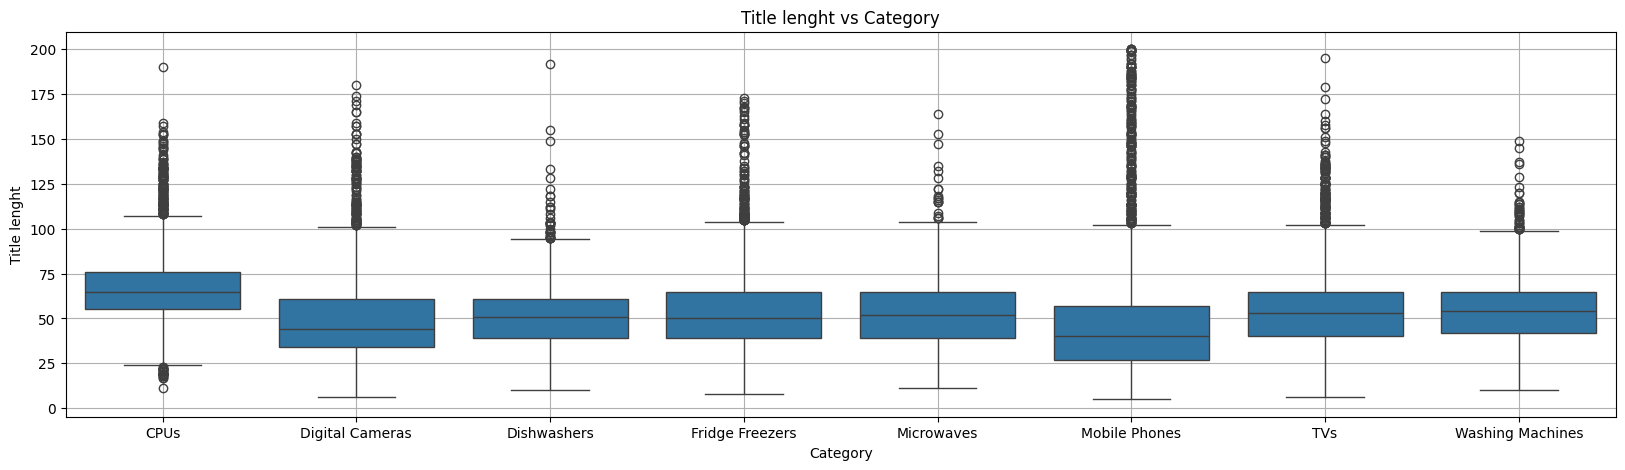

In [254]:
df.columns
print("*" * 40)
# we will definetly keep 'product_title' and 'category_label' columns

# checking if text length can be a useful feature

df['product_title_lenght'] = df['product_title'].astype(str).str.len()

print(df.groupby('category_label', observed=False)['product_title_lenght'].describe())



plt.figure(figsize=(20, 5))
sns.boxplot(data=df, x='category_label', y='product_title_lenght')
plt.title("Title lenght vs Category")
plt.xlabel("Category")
plt.ylabel("Title lenght")
plt.grid(True)
plt.show()

### Product lenght is not enough to predict product category 

### Dropping all columns except 'product_title' and category_label...

In [261]:

df = df.drop(columns=['product_id', 'merchant_id', '_product_code', 'number_of_views', 'merchant_rating', 'listing_date', 'product_title_lenght'])
#df = df.drop(columns=['product_title_lenght'])

print('Final dataset:', df.columns)

Final dataset: Index(['product_title', 'category_label'], dtype='object')


## 5: Algorithm selection:

In [256]:
X = df[["product_title"]]
y = df["category_label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Vectorizing

In [257]:
preprocessor = ColumnTransformer(
    transformers=[
        ("title", TfidfVectorizer(), "product_title"),
    ]
)


### Model selection

In [258]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": LinearSVC()
}

# Train and evaluate
for name, model in models.items():
    print(f"\n {name}")


    pipeline = Pipeline([
        ('preprocessing', preprocessor ),
        ('classifier', model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(classification_report(y_test, y_pred))


 Logistic Regression
                  precision    recall  f1-score   support

            CPUs       1.00      0.99      1.00       766
 Digital Cameras       1.00      0.99      0.99       538
     Dishwashers       0.96      0.91      0.94       681
 Fridge Freezers       0.94      0.99      0.97      2246
      Microwaves       1.00      0.94      0.97       466
   Mobile Phones       0.99      0.99      0.99       812
             TVs       0.98      0.98      0.98       708
Washing Machines       0.99      0.92      0.95       803

        accuracy                           0.97      7020
       macro avg       0.98      0.97      0.97      7020
    weighted avg       0.97      0.97      0.97      7020


 Naive Bayes
                  precision    recall  f1-score   support

            CPUs       1.00      1.00      1.00       766
 Digital Cameras       1.00      0.99      0.99       538
     Dishwashers       0.98      0.89      0.93       681
 Fridge Freezers       0.94     

## Winner is SVM model (Support Vector Machine)


| Model               | Accuracy | Macro F1 | Weighted F1
| ------------------- | -------- | -------- | -----------
| Logistic Regression | 0.95     | 0.74     | 0.95        
| Naive Bayes         | 0.93     | 0.72     | 0.93        
| Decision Tree       | 0.93     | 0.72     | 0.93        
| Random Forest       | 0.95     | 0.73     | 0.94        
| SVM                 | 0.97     | 0.75     | 0.96        

## 6. Model training

In [259]:
pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("Support Vector Machine", LinearSVC())
])


pipeline.fit(X, y)

joblib.dump(pipeline, "../model/product_sorting_by_title.pkl")

print(" Model trained and saved as 'model/product_sorting_by_title.pkl'")


 Model trained and saved as 'model/product_sorting_by_title.pkl'


## 7. Model testing:

### Go to src/model_testing.py

## 8. Model exporting:

https://github.com/ddarko98/ml_product_sorting_darko_spasojevic/tree/master